In [1]:
from time import sleep
from os import chdir, mkdir
from os.path import isdir, isfile

try:
    chdir(r'A:\_Projetos\AnotacoesEstudosBackPythonLSP\Home\acoes')
except:
    chdir(r'C:\Users\GOMEE11\Documents\_Referencias\Git\AnotacoesEstudosBackPythonLSP\Home\acoes')

for d in ['.\\Graph', '.\\Tables']:
    if isdir(d):
        pass
    else:
        mkdir(d)
        pass

from matplotlib import pyplot as plt
import pandas as pd
from pandas_datareader import DataReader as wb
import numpy as np
from make_data import Down_Data, Analisys, Graph
import datetime

try:
    from selenium import webdriver
    selenium = True
    fundSite = 'http://www.fundamentus.com.br/detalhes.php?papel='
    xpath_price = '/html/body/div[1]/div[2]/table[1]/tbody/tr[1]/td[4]'
    xpath_lpa = '/html/body/div[1]/div[2]/table[3]/tbody/tr[2]/td[6]'
    xpath_vpa = '/html/body/div[1]/div[2]/table[3]/tbody/tr[3]/td[6]'
    xpath_numero_acoes = '/html/body/div[1]/div[2]/table[2]/tbody/tr[2]/td[4]'
    xpath_patrimonio_liquido = '/html/body/div[1]/div[2]/table[4]/tbody/tr[4]/td[4]'
    xpath_yield = '/html/body/div[1]/div[2]/table[3]/tbody/tr[9]/td[4]/span'
    xpath_empresa = '/html/body/div[1]/div[2]/table[1]/tbody/tr[3]/td[2]/span'
    xpath_setor = '/html/body/div[1]/div[2]/table[1]/tbody/tr[4]/td[2]'
    pass
except:
    pass

plt.style.use('seaborn')
# plt.style.available

%matplotlib inline

In [2]:
try:
    driver.quit()
except:
    pass
if selenium is True:
    try:
        chrome_options = webdriver.ChromeOptions()
        chrome_options.arguments.append('headless')
        #chrome_options.set_headless = True
        try:
            driver = webdriver.Chrome('A:/chromedriver.exe', options=chrome_options)
        except:
            driver = webdriver.Chrome('C:/Users/GOMEE11/Documents/_Referencias/Git/chromedriver.exe', options=chrome_options)
        driver.minimize_window()
        selenium = True
        pass
    except:
        selenium = False
        pass
    pass

# Analise individual de Ticker

### Analise Técnica

In [3]:
dia = f'{datetime.datetime.now().year}-{datetime.datetime.now().month}-{datetime.datetime.now().day}'

# Indice Bovespa para Comparação

indice_bovespa = wb('^BVSP', data_source='yahoo', start='2018-1-1')['Adj Close']
indice_bovespa_returns = (indice_bovespa / indice_bovespa.shift(1)) - 1
indice_bovespa_annual_returns = indice_bovespa_returns.mean() * 250
indice_bovespa_annual_risk = indice_bovespa_returns.std() * 250 ** 0.5

"B3SA3", "BIDI4", "MGLU3", "BMEB4", "DTEX3", "MRFG3", "CRIV4",
"GOAU4", "BEES3", "CTSA3", "SQIA3", "WEGE3", "VVAR3", "QUAL3",
"EGIE3", "COGN3", "ENEV3", "SULA4"

In [79]:
ticker = 'VVAR3'

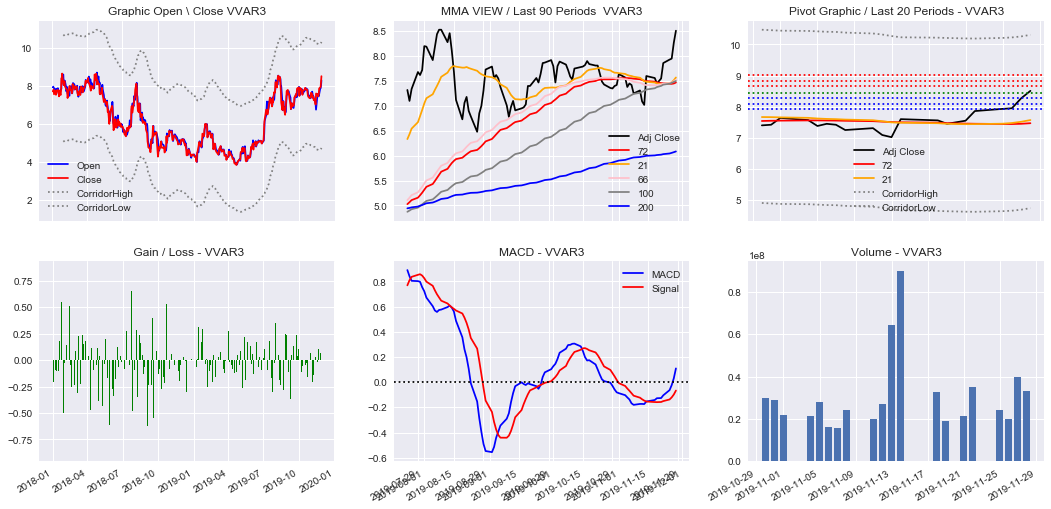

In [80]:
target = Down_Data(ticker)
analise = Analisys(target, ticker)
graph = Graph(target, ticker)

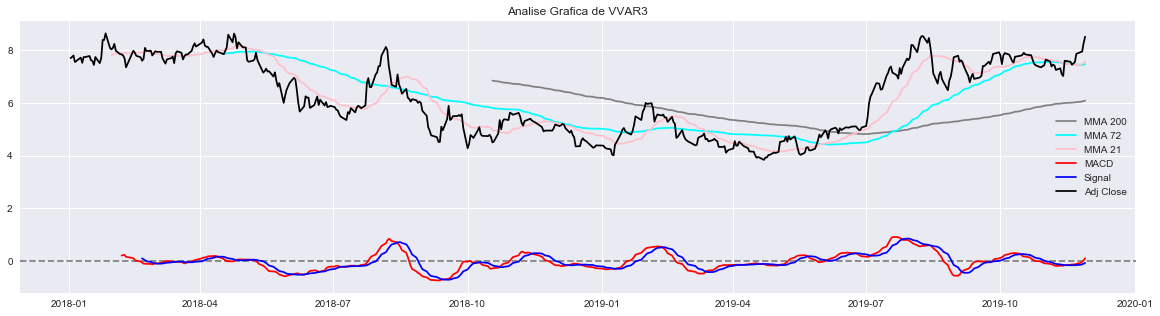

In [81]:
plt.figure(figsize=(20, 5))

plt.plot(analise['MMA200'], color='Grey', label='MMA 200')
plt.plot(analise['MMA72'], color='Cyan', label='MMA 72')
plt.plot(analise['MMA21'], color='Pink', label='MMA 21')

plt.axhline(0, color='Grey', linestyle="--")

plt.plot(analise['MACD'], color='Red', label='MACD')
plt.plot(analise['Signal'], color='Blue', label='Signal')

plt.plot(analise['Adj Close'], color='Black', label='Adj Close')

plt.title(f'Analise Grafica de {ticker}')

plt.legend()

plt.show()

## Análise de Risco
### Taxa de Retorno / Taxa de Risco

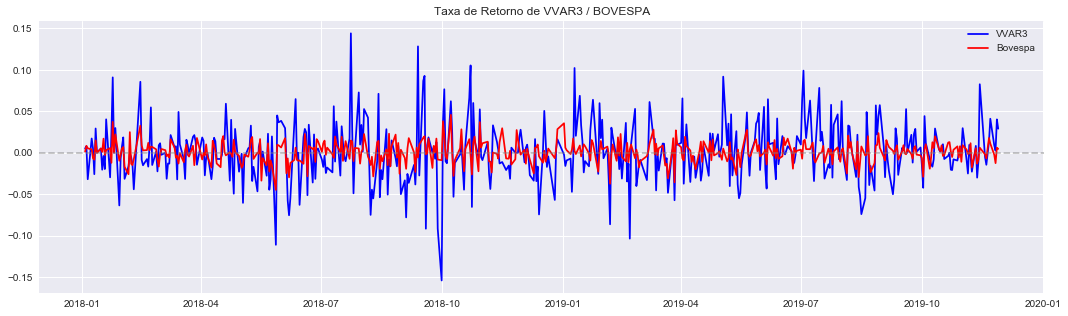

In [82]:
returns = (analise['Adj Close'] / analise['Adj Close'].shift(1)) - 1
annual_returns = returns.mean() * 250
annual_risk = returns.std() * 250 ** 0.5

# Graph

plt.figure(figsize=(18, 5))

plt.plot(returns, color='Blue', label=f'{ticker}')
plt.plot(indice_bovespa_returns, color='Red', label='Bovespa')
plt.axhline(0, color='Grey', linestyle="--", alpha=0.5)

plt.legend()

plt.title(f'Taxa de Retorno de {ticker} / BOVESPA')

plt.show()

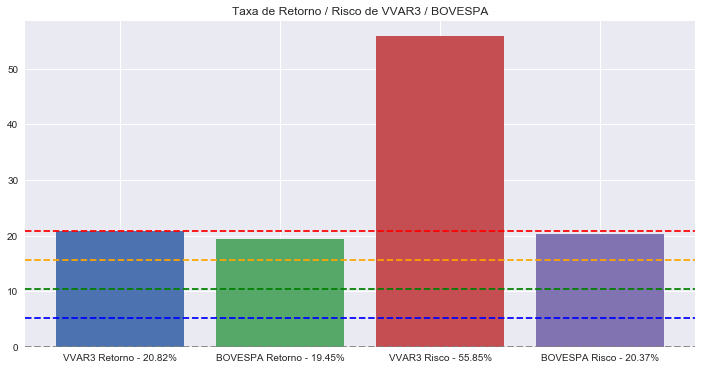

In [83]:
plt.figure(figsize=(12, 6))

plt.bar(f'{ticker} Retorno - {annual_returns * 100:.2f}%', annual_returns * 100)
plt.bar(f'BOVESPA Retorno - {indice_bovespa_annual_returns * 100:.2f}%', indice_bovespa_annual_returns * 100)
plt.bar(f'{ticker} Risco - {annual_risk * 100:.2f}%', annual_risk * 100)
plt.bar(f'BOVESPA Risco - {indice_bovespa_annual_risk * 100:.2f}%', indice_bovespa_annual_risk * 100)

plt.axhline(0, color='Grey', linestyle="--")
plt.axhline((annual_returns * 100) * 0.25, color='Blue', linestyle="--")
plt.axhline((annual_returns * 100) * 0.5, color='Green', linestyle="--")
plt.axhline((annual_returns * 100) * 0.75, color='Orange', linestyle="--")
plt.axhline((annual_returns * 100), color='Red', linestyle="--")

plt.title(f'Taxa de Retorno / Risco de {ticker} / BOVESPA')

plt.show()

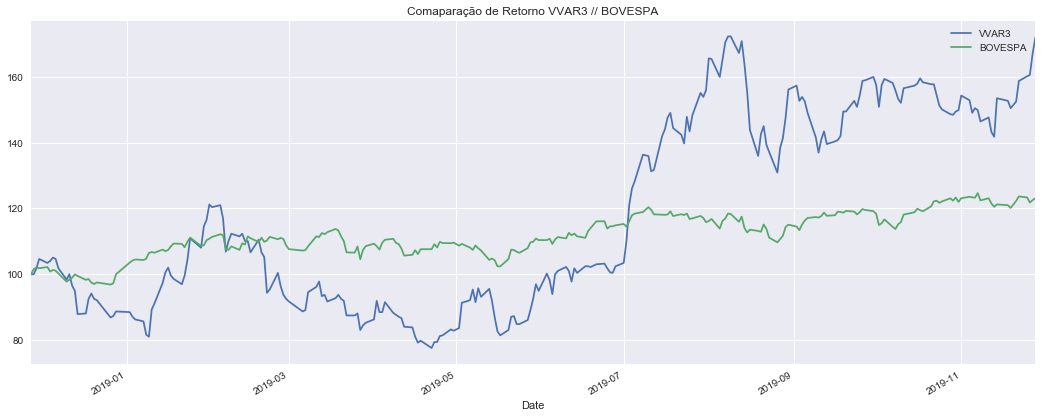

In [84]:
Comparacao_Normalizado = pd.DataFrame()
Comparacao_Normalizado[f'{ticker}'] = analise['Adj Close'][-250:]
Comparacao_Normalizado['BOVESPA'] = indice_bovespa[-250:]

(Comparacao_Normalizado / Comparacao_Normalizado.iloc[0] * 100).plot(figsize=(18,7))

plt.title(f'Comaparação de Retorno {ticker} // BOVESPA')
plt.show()

### Covariancia / Correlação
Quanto maior a Diferença de Correlação maior o fator de diversificação

In [85]:
wheights = np.array([0.5, 0.5])

secury_data = pd.DataFrame()
secury_data[ticker] = analise['Adj Close']
secury_data['BOVESPA'] = indice_bovespa
secury_returns = np.log(secury_data / secury_data.shift(1))

variance_compare = np.dot(wheights.T, np.dot(secury_returns.cov() * 250, wheights))
variance_ticker = secury_returns[ticker].var() * 250
variance_bovespa = secury_returns['BOVESPA'].var() * 250

covariance_ticker = secury_returns[ticker].cov
covariance_bovespa = secury_returns['BOVESPA'].cov

print(f'Variancia {ticker} : {variance_ticker * 100:0.3f}% / BOVESPA : {variance_bovespa * 100:0.3f}% / Comparação : {variance_compare * 100:0.3f}%\n')

print('--- Covariancia entre Ações ---')
print(secury_returns.cov() * 250)

print('\n--- Correlação entre Ações ---')
print(secury_returns.corr())

Variancia VVAR3 : 31.091% / BOVESPA : 4.148% / Comparação : 11.330%

--- Covariancia entre Ações ---
            VVAR3   BOVESPA
VVAR3    0.310914  0.050405
BOVESPA  0.050405  0.041479

--- Correlação entre Ações ---
            VVAR3   BOVESPA
VVAR3    1.000000  0.443851
BOVESPA  0.443851  1.000000


### Analise Fundamentalista
http://www.fundamentus.com.br/detalhes.php?papel=

In [86]:
Preco = analise['Adj Close'][-1]

if selenium is True:
    driver.get(fundSite + ticker)

    NroAcoes = driver.find_element_by_xpath(xpath_numero_acoes).text
    NroAcoes = float(NroAcoes.replace('.', ''))

    VPatriLiq = driver.find_element_by_xpath(xpath_patrimonio_liquido).text
    VPatriLiq = float(VPatriLiq.replace('.', ''))

    LPA = driver.find_element_by_xpath(xpath_lpa).text
    LPA = float(LPA.replace(',', '.'))

    VPA = driver.find_element_by_xpath(xpath_vpa).text
    VPA = float(VPA.replace(',', '.'))

    YIELD = driver.find_element_by_xpath(xpath_yield).text
    YIELD = YIELD.replace(',', '.')
    YIELD = float(YIELD.replace('%', ''))

    NOME_EMPRESA = driver.find_element_by_xpath(xpath_empresa).text
    SETOR = driver.find_element_by_xpath(xpath_setor).text

    V_VP = Preco / (VPatriLiq / NroAcoes)

    if (VPA > 0) and (LPA > 0):
        VIntrinseco = (22.5 * LPA * VPA) ** 0.5
        JustoSimNao = (VIntrinseco - Preco) - 1
        if JustoSimNao > 0:
            JustoSimNao = 'Sim'
        else:
            JustoSimNao = 'Não'
    else:
        VIntrinseco = 0
        JustoSimNao = 'Nro. Complexo'

    FundReport = pd.DataFrame(
        [
            [
            ticker,
            Preco,
            round(V_VP, 5),
            VIntrinseco,
            JustoSimNao,
            f'{annual_returns * 100:.2f}%',
            LPA,
            VPA,
            f'{YIELD:0.2f}%',
            f'{VPatriLiq:.1f}',
            f'{NroAcoes:.0f}',
            NOME_EMPRESA,
            SETOR
            ]
            ],
        columns=[
            'Ticker',
            'Preco',
            'V/VP',
            'Valor Intrinseco',
            'Preço Justo',
            'Retorno Anual',
            'LPA',
            'VPA',
            'YIELD',
            'Valor Patrimonial',
            'Numero Acoes',
            'NOME EMPRESA',
            'Setor'
            ],
        index=[dia]
        )
else:
    FundReport = None
    print(
        '''
        Não é possivel estimar no momento.
        Verifique se o Chromedrive está funcionando na mesma versão do chrome
        e se o modulo Selenium está instalado corretamente...
        '''
        )

FundReport

,Ticker,Preco,V/VP,Valor Intrinseco,Preço Justo,Retorno Anual,LPA,VPA,YIELD,Valor Patrimonial,Numero Acoes,NOME EMPRESA,Setor
2019-11-28,VVAR3,8.51,7.50341,0,Nro. Complexo,20.82%,-0.66,1.13,0.00%,1474000000.0,1299650000,VIAVAREJO ON,Comércio


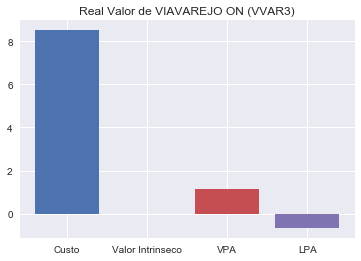

In [87]:
plt.bar('Custo', FundReport['Preco'], label='Preco')
plt.bar('Valor Intrinseco', FundReport['Valor Intrinseco'], label='Valor Intrinseco')
plt.bar('VPA', FundReport['VPA'], label='Valor Por Ação')
plt.bar('LPA', FundReport['LPA'], label='Lucro Por Ação')


plt.title(f'Real Valor de {NOME_EMPRESA} ({ticker})')

plt.show()

In [88]:
print(f'- Lote de 100 ({ticker}) -\nPreço de Compra : {Preco * 100:.2f}\nLucro no Alvo : {(VIntrinseco - Preco) * 100:.2f}\nCash Final : {(Preco + (VIntrinseco - Preco)) * 100:.2f}\nLucro Anual por Lote : {(LPA * (YIELD / 100) ) * 100:0.2f}')

- Lote de 100 (VVAR3) -
Preço de Compra : 851.00
Lucro no Alvo : -851.00
Cash Final : 0.00
Lucro Anual por Lote : -0.00


In [0]:
off = False
if off is True:
    try:
        driver.quit()
    except:
        pass